#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

Loading the required libraries

In [ ]:
#ting der skal prøves!
"""
early stopping

leave one out

dropout

måske leaky_relu istedet for relu



"""

In [57]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"   # Delete if you have GPU's available
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Defining a function that splits images and labels and one-hot-encodes the labels

In [26]:
#vi bruger nedenstående med onehot encoding til CNN-delen
"""
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label
"""

"\ndef convert_sample(sample):\n    image, label = sample['image'], sample['label']  \n    image = tf.image.convert_image_dtype(image, tf.float32)\n    label = tf.one_hot(label, 2, dtype=tf.float32)\n    return image, label\n"

In [65]:
#convert_sample UDEN one-hot encoding
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image itself as the target label

Next we use the tensorflow dataset API - tfds - to load the data from you local directory. First you have to download the data manually from https://syddanskuni-my.sharepoint.com/:f:/g/personal/cmd_sam_sdu_dk/EiWD2LmuxCJBp-_tfGK7aL8Bdt2cPsb6MCpVs1pOYUcXAw?email=cmd%40sam.sdu.dk&e=2Vx6tL and store it on you local drive. First some important remarks:
- The folder structure is **crucial** and needs to be copied to your local drive. For example, if you with to use the folder denoted *c:\user\aml_take_home_exam* then you need to download the data to *c:\user\aml_take_home_exam\patch_camelyon\2.0.0*.
- As you can see from the example below this implies that my data is stored locally under *V:\BDADShareData2\DATA_TFDS_BDAD\patch_camelyon\2.0.0*
- By using tfds.load you do not need to load all data. If you only want 20% of the training data and 5% of test and validation data you simply specify **split=['train[:20%]','test[:5%]','validation[:5%]']**. In this case the variable ds1 contains only 20 percent of the training data while ds2 and ds3 contains 5% of the test and validation data respectively. This feature is important if you are facing hardware contraints.
- You can read more about tensorflow dataset here https://www.tensorflow.org/datasets 
- **Note** If you wish not to use data stored locally you can use download=True and tensorflow will download the data for you. 

In [ ]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:10%]','test[:2.5%]','validation[:2.5%]'],
                        data_dir = r'C:\Job_og_eksamensbevis\Github\projekter\Projekt_1_Computer_Vision',
                        download=False,
                        shuffle_files=True)

Next we simple transform the data (by the function convert sample described previously) and getting ready for training by splitting it into batches.

In [67]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

The data is then ready to be applied for training, validation, testing etc...below just a very very simple illustration on how to construct and train a model based on the data we have prepared

In [61]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape


# Encoder
input_shape = (96, 96, 3)
latent_dim = 64

def build_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu')(x)
    return Model(inputs, encoded)

# Decoder
def build_decoder(latent_dim, input_shape):
    inputs = Input(shape=(latent_dim,))
    x = Dense(24 * 24 * 32, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Reshape((24, 24, 32))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 
    return Model(inputs, decoded)

# Autoencoder
encoder = build_encoder(input_shape)
decoder = build_decoder(latent_dim, input_shape)
autoencoder = tf.keras.Sequential([encoder, decoder])

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


# Print the summary of the autoencoder
autoencoder.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_40 (Functional)       (None, 64)                1200736   
                                                                 
 model_41 (Functional)       (None, 96, 96, 3)         1376163   
                                                                 
Total params: 2576899 (9.83 MB)
Trainable params: 2539139 (9.69 MB)
Non-trainable params: 37760 (147.50 KB)
_________________________________________________________________


In [71]:


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping

# Encoder
input_shape = (96, 96, 3)
latent_dim = 64
dropout_rate = 0.2

def build_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs) #64
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) #32
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu')(x)
    encoded = Dropout(dropout_rate)(encoded)  # Adding dropout
    return Model(inputs, encoded)

# Decoder
def build_decoder(latent_dim, input_shape):
    inputs = Input(shape=(latent_dim,))
    x = Dense(24 * 24 * 32, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Reshape((24, 24, 32))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) #32
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x) #64
    x = BatchNormalization()(x)
    x = Conv2DTranspose(3, (3, 3), strides=(2, 2), activation='sigmoid', padding='same')(x)
    return Model(inputs, x)


# Define the autoencoder model
encoder = build_encoder(input_shape)
decoder = build_decoder(latent_dim, input_shape)
autoencoder = Model(encoder.input, decoder(encoder.output))

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the autoencoder with early stopping
autoencoder.fit(train_dataset, 
                validation_data=validation_dataset, 
                epochs=10, 
                callbacks=[early_stopping]
                )

Epoch 1/10
820/820 [==============================] - 182s 218ms/step - loss: 0.0405 - val_loss: 0.0377
Epoch 2/10
820/820 [==============================] - 181s 221ms/step - loss: 0.0359 - val_loss: 0.0417
Epoch 3/10
820/820 [==============================] - 177s 215ms/step - loss: 0.0351 - val_loss: 0.0362
Epoch 4/10
820/820 [==============================] - 179s 219ms/step - loss: 0.0349 - val_loss: 0.0379
Epoch 5/10
820/820 [==============================] - 180s 220ms/step - loss: 0.0343 - val_loss: 0.0375
Epoch 6/10
820/820 [==============================] - 181s 220ms/step - loss: 0.0351 - val_loss: 0.0358
Epoch 7/10
820/820 [==============================] - 181s 220ms/step - loss: 0.0342 - val_loss: 0.0352
Epoch 8/10
820/820 [==============================] - 172s 210ms/step - loss: 0.0338 - val_loss: 0.0360
Epoch 9/10
820/820 [==============================] - 170s 208ms/step - loss: 0.0336 - val_loss: 0.0359
Epoch 10/10
820/820 [==============================] - 166s 202m

In [47]:
"""
#gridsearch for batchsize, learningrate, latent space, filters
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape

# Encoder
def build_encoder(input_shape, filters1, filters2):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters1, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters2, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation='relu')(x)
    return Model(inputs, encoded)

# Decoder
def build_decoder(latent_dim, input_shape, filters1, filters2):
    inputs = Input(shape=(latent_dim,))
    x = Dense(24 * 24 * filters2, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Reshape((24, 24, filters2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters2, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters1, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters1, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters1, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(inputs, decoded)

# Grid search parameters
latent_dim_candidates = [32, 64]
batch_size_candidates = [16, 32, 64]
learning_rate_candidates = [0.001, 0.01, 0.1]
filters1_candidates = [32, 64, 128]
filters2_candidates = [32, 64, 128]

results = []

for latent_dim in latent_dim_candidates:
    for batch_size in batch_size_candidates:
        for learning_rate in learning_rate_candidates:
            for filters1 in filters1_candidates:
                for filters2 in filters2_candidates:
                    print(f"Testing Latent Dimension: {latent_dim}, Batch Size: {batch_size}, Learning Rate: {learning_rate}, Filters1: {filters1}, Filters2: {filters2}")
                    
                    # Build a new encoder, decoder, and autoencoder for each combination of parameters
                    encoder = build_encoder(input_shape, filters1, filters2)
                    decoder = build_decoder(latent_dim, input_shape, filters1, filters2)
                    autoencoder = tf.keras.Sequential([encoder, decoder])

                    # Compile the autoencoder with the specified learning rate
                    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

                    # Train the autoencoder
                    autoencoder.fit(train_dataset, epochs=10, batch_size=batch_size, validation_data=validation_dataset, verbose=1)

                    # Evaluate performance (you may use a validation set or a separate test set)
                    loss = autoencoder.evaluate(train_dataset, verbose=1)

                    # Save the results
                    results.append({'latent_dim': latent_dim, 'batch_size': batch_size, 'learning_rate': learning_rate, 'filters1': filters1, 'filters2': filters2, 'loss': loss})

# Print the results
for result in results:
    print(f"Latent Dimension: {result['latent_dim']}, Batch Size: {result['batch_size']}, Learning Rate: {result['learning_rate']}, Filters1: {result['filters1']}, Filters2: {result['filters2']}, Loss: {result['loss']}")



autoencoder.summary()
"""

Testing Latent Dimension: 32, Batch Size: 16, Learning Rate: 0.001, Filters1: 32, Filters2: 32
Epoch 1/10
1639/1639 [==============================] - 331s 200ms/step - loss: 0.0367 - val_loss: 0.0379
Epoch 2/10
1639/1639 [==============================] - 326s 199ms/step - loss: 0.0334 - val_loss: 0.0385
Epoch 3/10
1639/1639 [==============================] - 326s 199ms/step - loss: 0.0325 - val_loss: 0.0358
Epoch 4/10
1639/1639 [==============================] - 322s 197ms/step - loss: 0.0322 - val_loss: 0.0368
Epoch 5/10
1639/1639 [==============================] - 329s 201ms/step - loss: 0.0320 - val_loss: 0.0361
Epoch 6/10
1639/1639 [==============================] - 322s 196ms/step - loss: 0.0320 - val_loss: 0.0361
Epoch 7/10
1639/1639 [==============================] - 324s 197ms/step - loss: 0.0319 - val_loss: 0.0348
Epoch 8/10
1639/1639 [==============================] - 322s 196ms/step - loss: 0.0318 - val_loss: 0.0362
Epoch 9/10
1639/1639 [==============================] - 3

KeyboardInterrupt: 

In [62]:
#fitting the model
history = autoencoder.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=10,
                          batch_size=32
                          )

Epoch 1/10
1639/1639 [==============================] - 877s 532ms/step - loss: 0.0363 - val_loss: 0.0373
Epoch 2/10
1639/1639 [==============================] - 883s 539ms/step - loss: 0.0319 - val_loss: 0.0349
Epoch 3/10
1639/1639 [==============================] - 869s 530ms/step - loss: 0.0311 - val_loss: 0.0357
Epoch 4/10
1639/1639 [==============================] - 757s 462ms/step - loss: 0.0310 - val_loss: 0.0350
Epoch 5/10
1639/1639 [==============================] - 740s 452ms/step - loss: 0.0308 - val_loss: 0.0389
Epoch 6/10
1639/1639 [==============================] - 757s 462ms/step - loss: 0.0307 - val_loss: 0.0342
Epoch 7/10
1639/1639 [==============================] - 735s 448ms/step - loss: 0.0308 - val_loss: 0.0336
Epoch 8/10
1639/1639 [==============================] - 783s 478ms/step - loss: 0.0306 - val_loss: 0.0337
Epoch 9/10
1639/1639 [==============================] - 744s 454ms/step - loss: 0.0305 - val_loss: 0.0341
Epoch 10/10
1639/1639 [=======================

In [54]:
history = autoencoder.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=10,
                          batch_size=32
                          )


# Evaluate performance (you may use a validation set or a separate test set)
loss = autoencoder.evaluate(test_dataset, verbose=1)


# Access the training history
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot the training progress
import matplotlib.pyplot as plt

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
1639/1639 [==============================] - 810s 492ms/step - loss: 0.0356 - val_loss: 0.0395
Epoch 2/10
1639/1639 [==============================] - 753s 459ms/step - loss: 0.0321 - val_loss: 0.0355
Epoch 3/10
1639/1639 [==============================] - 741s 452ms/step - loss: 0.0318 - val_loss: 0.0352
Epoch 4/10
1639/1639 [==============================] - 739s 451ms/step - loss: 0.0317 - val_loss: 0.0343
Epoch 5/10
1639/1639 [==============================] - 739s 451ms/step - loss: 0.0315 - val_loss: 0.0354
Epoch 6/10
1639/1639 [==============================] - 16322s 10s/step - loss: 0.0314 - val_loss: 0.0346
Epoch 7/10
1639/1639 [==============================] - 781s 476ms/step - loss: 0.0313 - val_loss: 0.0340
Epoch 8/10
1639/1639 [==============================] - 784s 478ms/step - loss: 0.0312 - val_loss: 0.0340
Epoch 9/10
1639/1639 [==============================] - 784s 478ms/step - loss: 0.0311 - val_loss: 0.0340
Epoch 10/10
1639/1639 [=======================

NameError: name 'X_test' is not defined

1/1 [==============================] - 0s 216ms/step


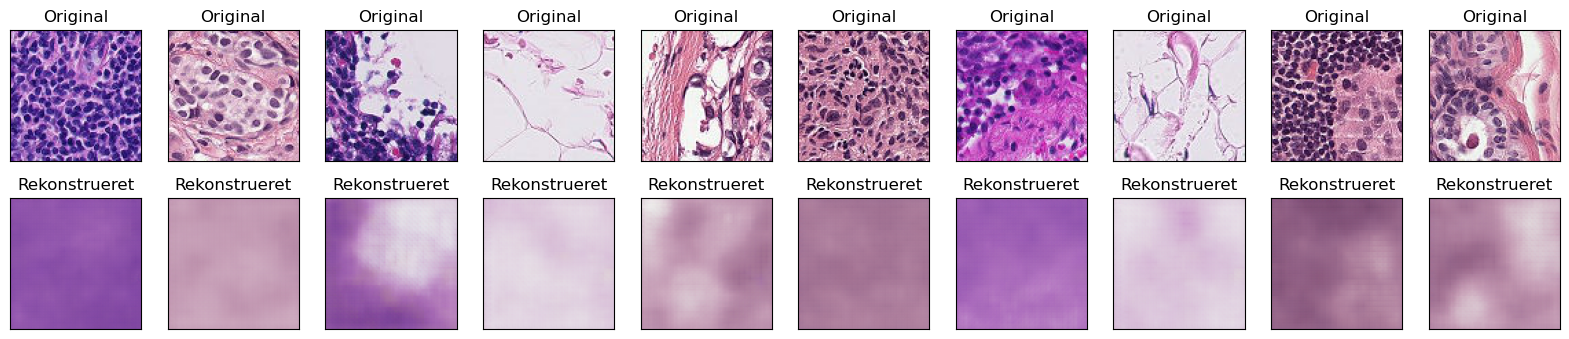

In [72]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Antal billeder at vise
n = 10

# Hent nogle eksempler fra testdatasættet
samples = next(iter(test_dataset))[0][:n]  # Brug kun inputbilleder

# Generer rekonstruerede billeder fra de originale billeder
reconstructed_images = autoencoder.predict(samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original")
    plt.imshow(tf.squeeze(samples[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display rekonstruktion
    bx = plt.subplot(2, n, i + 1 + n)
    plt.title("Rekonstrueret")
    plt.imshow(tf.squeeze(reconstructed_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

1/1 [==============================] - 0s 214ms/step


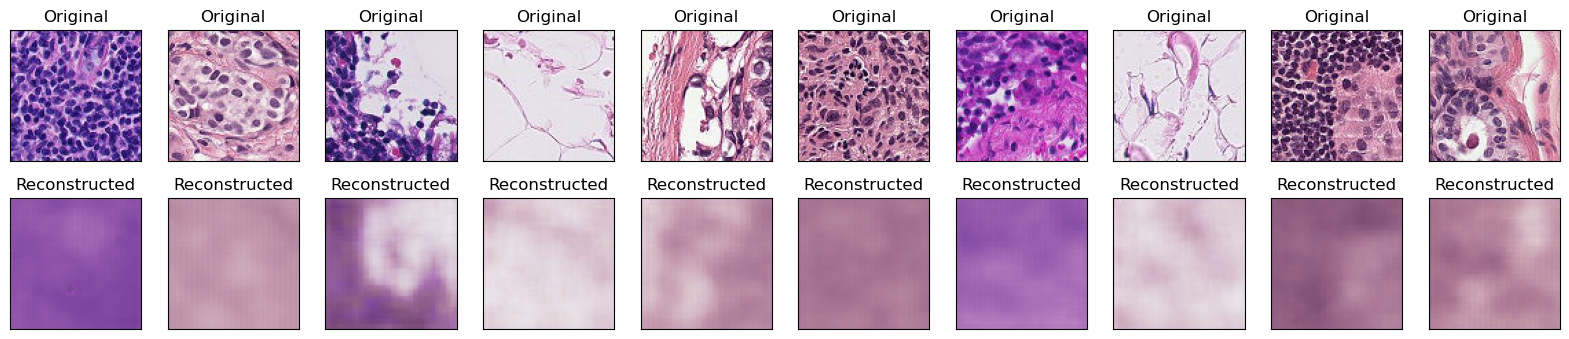

In [69]:


reconstructed_images = autoencoder.predict(samples)

plt.figure(figsize=(20, 4))
for i, (sample, reconstructed_image) in enumerate(zip(samples, reconstructed_images)):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original")
    plt.imshow(tf.squeeze(sample))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    bx = plt.subplot(2, n, i + 1 + n)
    plt.title("Reconstructed")
    plt.imshow(tf.squeeze(reconstructed_image))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()